# Toronto arrests for possesion of small quantities of Marijuana

# 1. Import Data

To start, install necessary libraries

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
%matplotlib inline

Import data as csv from link, the first column is the index column so set index_col to zero.

In [204]:
df = pd.read_csv("https://raw.githubusercontent.com/SieSiongWong/DATA-607/master/Arrests.csv", index_col=0)
df.head()

,released,colour,year,age,sex,employed,citizen,checks
1,Yes,White,2002,21,Male,Yes,Yes,3
2,No,Black,1999,17,Male,Yes,Yes,3
3,Yes,White,2000,24,Male,Yes,Yes,3
4,No,Black,2000,46,Male,Yes,Yes,1
5,Yes,Black,1999,27,Female,Yes,Yes,1


In [205]:
# list the data types for each column
df.dtypes

released    object
colour      object
year         int64
age          int64
sex         object
employed    object
citizen     object
checks       int64
dtype: object

check numerical data columns listed as int64

In [206]:
df.describe()

,year,age,checks
count,5226.000000,5226.000000,5226.000000
mean,1999.509376,23.846537,1.636433
std,1.390056,8.316133,1.539230
min,1997.000000,12.000000,0.000000
25%,1998.000000,18.000000,0.000000
50%,2000.000000,21.000000,1.000000
75%,2001.000000,27.000000,3.000000
max,2002.000000,66.000000,6.000000


In [207]:
df['checks'].value_counts()

0    1851
3     953
1     854
2     789
4     643
5     127
6       9
Name: checks, dtype: int64

the most arrests were made with people without criminal background shown as checks=0

In [208]:
df['year'].value_counts()

2000    1270
2001    1211
1999    1099
1998     877
1997     492
2002     277
Name: year, dtype: int64

number of arrests for possesion of small quantities of marijuana descreases over time

# 2. Data Cleanup


Apriori algorithm in Python works with only True, False, 0, 1 values.

1. Turn all Yes/No to True/False at released, employed, citizen
2. One-hot encode checks, year, colour, sex
3. Bin age column

In [209]:
odf = df
odf.dropna(subset=['released'], axis=0, inplace=True)

one-hot encode the year of arrests

In [210]:
odf = odf.join(pd.get_dummies(df['year'],prefix='year',drop_first=False))
odf = odf.drop('year',axis = 1)
odf.head()

,released,colour,age,sex,employed,citizen,checks,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002
1,Yes,White,21,Male,Yes,Yes,3,0,0,0,0,0,1
2,No,Black,17,Male,Yes,Yes,3,0,0,1,0,0,0
3,Yes,White,24,Male,Yes,Yes,3,0,0,0,1,0,0
4,No,Black,46,Male,Yes,Yes,1,0,0,0,1,0,0
5,Yes,Black,27,Female,Yes,Yes,1,0,0,1,0,0,0


change released, employed, citizen values from Yes/No to True/False

In [211]:
odf = odf.replace({'Yes': True, 'No': False})
odf.head()

,released,colour,age,sex,employed,citizen,checks,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002
1,True,White,21,Male,True,True,3,0,0,0,0,0,1
2,False,Black,17,Male,True,True,3,0,0,1,0,0,0
3,True,White,24,Male,True,True,3,0,0,0,1,0,0
4,False,Black,46,Male,True,True,1,0,0,0,1,0,0
5,True,Black,27,Female,True,True,1,0,0,1,0,0,0


Binary columns sex and colour are transformed into is_Male and is_White

In [212]:
odf = odf.join(pd.get_dummies(df['sex'],prefix='is',drop_first=False))
odf = odf.join(pd.get_dummies(df['colour'],prefix='is',drop_first=False))
odf = odf.drop('sex',axis = 1)
odf = odf.drop('colour',axis = 1)
odf.head()

,released,age,employed,citizen,checks,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,is_Female,is_Male,is_Black,is_White
1,True,21,True,True,3,0,0,0,0,0,1,0,1,0,1
2,False,17,True,True,3,0,0,1,0,0,0,0,1,1,0
3,True,24,True,True,3,0,0,0,1,0,0,0,1,0,1
4,False,46,True,True,1,0,0,0,1,0,0,0,1,1,0
5,True,27,True,True,1,0,0,1,0,0,0,1,0,1,0


the last part is the binning of age and checks. Starting with age there will be 3 categories

In [213]:
bins = np.linspace(min(odf['age']), max(odf['age']),4)
print(bins)
odf['age'] = pd.cut(odf['age'], bins, labels=['young','adult','old'], include_lowest=True)
odf.head()

[12. 30. 48. 66.]


,released,age,employed,citizen,checks,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,is_Female,is_Male,is_Black,is_White
1,True,young,True,True,3,0,0,0,0,0,1,0,1,0,1
2,False,young,True,True,3,0,0,1,0,0,0,0,1,1,0
3,True,young,True,True,3,0,0,0,1,0,0,0,1,0,1
4,False,adult,True,True,1,0,0,0,1,0,0,0,1,1,0
5,True,young,True,True,1,0,0,1,0,0,0,1,0,1,0


distribution of greated age groups

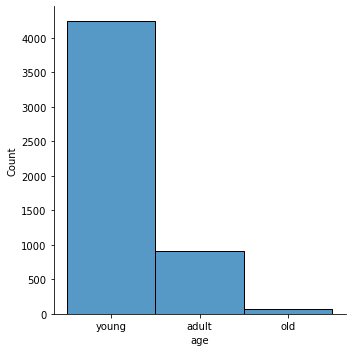

In [214]:
sns.displot(odf, x="age")

more one-hot encoding to fit data for the apriori function

In [215]:
odf = odf.join(pd.get_dummies(odf['age'],prefix='age',drop_first=False))
odf = odf.drop('age',axis = 1)

In [216]:
odf = odf.join(pd.get_dummies(odf['checks'],prefix='checks',drop_first=False))
odf = odf.drop('checks',axis = 1)
odf.head()

,released,employed,citizen,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,is_Female,...,age_young,age_adult,age_old,checks_0,checks_1,checks_2,checks_3,checks_4,checks_5,checks_6
1,True,True,True,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,False,True,True,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,True,True,True,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,False,True,True,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5,True,True,True,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [217]:
odf.columns

Index(['released', 'employed', 'citizen', 'year_1997', 'year_1998',
       'year_1999', 'year_2000', 'year_2001', 'year_2002', 'is_Female',
       'is_Male', 'is_Black', 'is_White', 'age_young', 'age_adult', 'age_old',
       'checks_0', 'checks_1', 'checks_2', 'checks_3', 'checks_4', 'checks_5',
       'checks_6'],
      dtype='object')

In [218]:
apriori.__code__.co_varnames

('df',
 'min_support',
 'use_colnames',
 'max_len',
 'verbose',
 'low_memory',
 '_support',
 'X',
 'is_sparse',
 'support',
 'ary_col_idx',
 'support_dict',
 'itemset_dict',
 'max_itemset',
 'rows_count',
 'all_ones',
 'next_max_itemset',
 'combin',
 '_bools',
 'n',
 '_mask',
 'all_res',
 'k',
 'itemsets',
 'res',
 'res_df')

In [219]:
frq_items = apriori(odf, min_support = 0.2, use_colnames = True)

In [220]:
frq_items['length'] = frq_items['itemsets'].apply(lambda x: len(x))
frq_items[(frq_items['length'] >= 2)].head()

,support,itemsets,length
11,0.68274,"(released, employed)",2
12,0.72235,"(released, citizen)",2
13,0.208955,"(released, year_2000)",2
14,0.756602,"(released, is_Male)",2
15,0.646575,"(released, is_White)",2


In [221]:
arules = association_rules(frq_items, metric="confidence", min_threshold=0.8)
arules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(released),(employed),0.829315,0.786644,0.682740,0.823258,1.046545,0.030365,1.207162
1,(employed),(released),0.786644,0.829315,0.682740,0.867915,1.046545,0.030365,1.292240
2,(released),(citizen),0.829315,0.852468,0.722350,0.871020,1.021762,0.015385,1.143832
3,(citizen),(released),0.852468,0.829315,0.722350,0.847363,1.021762,0.015385,1.118238
4,(year_2000),(released),0.243016,0.829315,0.208955,0.859843,1.036811,0.007419,1.217809


In [222]:
arules.sort_values('confidence').head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
385,"(is_White, checks_0, citizen)","(employed, age_young)",0.267317,0.652507,0.213930,0.800286,1.226480,0.039504,1.739958
207,"(age_young, checks_0)","(released, is_Male)",0.307884,0.756602,0.246460,0.800497,1.058017,0.013515,1.220025
376,"(is_Male, checks_0, citizen)","(is_White, employed)",0.261959,0.612323,0.209721,0.800584,1.307454,0.049317,1.944065
365,"(is_Male, age_young, checks_0)","(is_White, released)",0.268848,0.646575,0.215270,0.800712,1.238390,0.041439,1.773437
317,"(is_Male, employed, checks_0)","(is_White, released)",0.276693,0.646575,0.221584,0.800830,1.238573,0.042681,1.774489


filter only for consequents released

In [223]:
arules[arules['consequents']=={'released'}].sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(is_Male),(released),0.915232,0.829315,0.756602,0.826678,0.996820,-0.002414,0.984785
65,"(is_Male, age_young)",(released),0.743781,0.829315,0.620742,0.834577,1.006345,0.003914,1.031808
9,(age_young),(released),0.812476,0.829315,0.679679,0.836552,1.008727,0.005880,1.044278
52,"(is_Male, citizen)",(released),0.774206,0.829315,0.655186,0.846268,1.020442,0.013125,1.110276
3,(citizen),(released),0.852468,0.829315,0.722350,0.847363,1.021762,0.015385,1.118238
178,"(is_Male, age_young, citizen)",(released),0.636051,0.829315,0.542863,0.853490,1.029150,0.015376,1.165004
58,"(age_young, citizen)",(released),0.699770,0.829315,0.597589,0.853979,1.029740,0.017259,1.168905
62,"(is_White, is_Male)",(released),0.682549,0.829315,0.585151,0.857303,1.033748,0.019103,1.196137
7,(is_White),(released),0.753540,0.829315,0.646575,0.858050,1.034649,0.021653,1.202429
4,(year_2000),(released),0.243016,0.829315,0.208955,0.859843,1.036811,0.007419,1.217809


definintely not the same results as R. For starters the max confidence is way lower and support is way higher than the R version

In [224]:
arules["antecedent_len"] = arules["antecedents"].apply(lambda x: len(x))
arules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(released),(employed),0.829315,0.786644,0.682740,0.823258,1.046545,0.030365,1.207162,1
1,(employed),(released),0.786644,0.829315,0.682740,0.867915,1.046545,0.030365,1.292240,1
2,(released),(citizen),0.829315,0.852468,0.722350,0.871020,1.021762,0.015385,1.143832,1
3,(citizen),(released),0.852468,0.829315,0.722350,0.847363,1.021762,0.015385,1.118238,1
4,(year_2000),(released),0.243016,0.829315,0.208955,0.859843,1.036811,0.007419,1.217809,1


In [225]:
arules[(arules['antecedent_len']>=2)&
       (arules['consequents']=={'released'})].sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
65,"(is_Male, age_young)",(released),0.743781,0.829315,0.620742,0.834577,1.006345,0.003914,1.031808,2
52,"(is_Male, citizen)",(released),0.774206,0.829315,0.655186,0.846268,1.020442,0.013125,1.110276,2
178,"(is_Male, age_young, citizen)",(released),0.636051,0.829315,0.542863,0.853490,1.029150,0.015376,1.165004,3
58,"(age_young, citizen)",(released),0.699770,0.829315,0.597589,0.853979,1.029740,0.017259,1.168905,2
62,"(is_White, is_Male)",(released),0.682549,0.829315,0.585151,0.857303,1.033748,0.019103,1.196137,2
41,"(is_Male, employed)",(released),0.724455,0.829315,0.625144,0.862916,1.040517,0.024342,1.245113,2
55,"(is_White, citizen)",(released),0.676234,0.829315,0.585534,0.865874,1.044084,0.024723,1.272576,2
173,"(is_White, is_Male, citizen)",(released),0.609453,0.829315,0.527746,0.865934,1.044156,0.022318,1.273142,3
69,"(is_White, age_young)",(released),0.615193,0.829315,0.535400,0.870295,1.049415,0.025211,1.315953,2
199,"(is_White, age_young, is_Male)",(released),0.557597,0.829315,0.485457,0.870625,1.049812,0.023034,1.319300,3
